# Import and misc

In [1]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from thop import profile
import tempfile

/home/dpozdeev/anaconda3/envs/dla-kws/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def fix_seed(seed):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

In [3]:
fix_seed(9999)

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [4]:
@dataclasses.dataclass
class BaseConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 32
    gru_num_layers: int = 2
    bidirectional: bool = False
    dropout: float = 0.
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

    alpha: float = 0.
    temp: float = 1.

# Data

In [5]:
# !wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# !mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

In [6]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [7]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=BaseConfig.keyword
)

In [8]:
dataset.csv.sample(5)

,path,keyword,label
39918,speech_commands/bed/db9d52d2_nohash_1.wav,bed,0
58118,speech_commands/tree/15f04ff8_nohash_0.wav,tree,0
16952,speech_commands/down/bc196f81_nohash_1.wav,down,0
42169,speech_commands/no/0f7dc557_nohash_0.wav,no,0
55518,speech_commands/six/15b0c947_nohash_2.wav,six,0


### Augmentations

In [9]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [10]:
from sklearn.model_selection import train_test_split
train_indexes, val_indexes = train_test_split(np.arange(len(dataset)), train_size=0.8, random_state=42)

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [11]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [12]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [13]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [14]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [15]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=BaseConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=BaseConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [16]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [17]:
melspec_train = LogMelspec(is_train=True, config=BaseConfig)
melspec_val = LogMelspec(is_train=False, config=BaseConfig)

### Quality measurment functions:

In [18]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [19]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [20]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=config.dropout,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

In [21]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)

        batch = log_melspec(batch)
        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [22]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [23]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

# Training

In [24]:
from thop import profile
import tempfile
from copy import deepcopy

@torch.no_grad()
def get_number_of_flops_per_layer(model):
    results = {}
    def add_results(module_name, x):
        module = getattr(model, module_name)
        if module_name == 'conv':
            module = module[0]
        results[module_name] = profile(module, (x, ))[0]
    
    x = melspec_val(torch.rand(size=[1, model.config.sample_rate * 2]).to(model.config.device)).unsqueeze(1)
    
    add_results('conv', x)
    conv_output = model.conv(x).transpose(-1, -2)
    
    add_results('gru', conv_output)
    gru_output, _ = model.gru(conv_output)

    add_results('attention', gru_output)
    contex_vector = model.attention(gru_output)
    
    add_results('classifier', contex_vector)
    output = model.classifier(contex_vector)
    
    return results

class Metrics:

    def __init__(self, base_model):
        self.base_macs = Metrics.get_macs(base_model)
        self.base_mbs = Metrics.get_size_in_megabytes(base_model)

        self.val_metric = validation(base_model, val_loader, melspec_val, config.device)
        
    @staticmethod
    def get_macs(model):
        test_input = melspec_val(torch.rand(size=[1, model.config.sample_rate * 2]).to(model.config.device))
        return profile(model, test_input.unsqueeze(0))[0]  # -> (6.0 MACs, 3.0 parameters)

    @staticmethod
    def get_size_in_megabytes(model):
        # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
        with tempfile.TemporaryFile() as f:
            torch.save(model.state_dict(), f)
            size = f.tell() / 2**20
        return size


    def __call__(self, new_model):
        new_macs = Metrics.get_macs(new_model)
        new_base_mbs = Metrics.get_size_in_megabytes(new_model)

        new_val_metric = validation(new_model, val_loader, melspec_val, config.device)

        print('Macs improvement', self.base_macs / new_macs)
        print('Mbs imporvement', self.base_mbs / new_base_mbs)
        print('Val metric', new_val_metric)
    

In [25]:
import utils
path = '/home/dpozdeev/dla-kws/save/Base/1105_021522/Base_sched=False.tar'
'/home/dpozdeev/dla-kws/save/Base/1105_013259/Base_sched=False.tar'
base_model = utils.load_model(path)

## Basemodel

In [27]:
history = defaultdict(list)

config = BaseConfig(hidden_size=32)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [28]:
sum([p.numel() for p in model.parameters()])

25387

In [29]:
# TRAIN

for n in range(BaseConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

 12%|█████████████▉                                                                                                          | 47/405 [00:02<00:19, 18.68it/s]


KeyboardInterrupt: 

In [28]:
history

defaultdict(list,
            {'val_metric': [0.000878691543582268,
              0.0005494858137221071,
              0.0003482899470245882,
              0.0002472295287382919,
              0.00020715744673105948,
              0.0002004618583450409,
              0.00015874273320541895,
              0.0001486754804360666,
              0.00012938239910630008,
              0.0001367761905593099,
              0.00013489641307125653,
              0.00013697908717706802,
              0.00010787535762393739,
              0.00010610299599234423,
              0.00010385323055426135,
              0.00010297003351225532,
              0.00010408596490992509,
              9.067688549514459e-05,
              0.00010223602515977735,
              9.161379046538068e-05]})

In [28]:
torch.save(model.state_dict(), 'base_model.pth')

## Knowledge Distillation

In [30]:
# https://github.com/szagoruyko/attention-transfer/blob/master/utils.py#L10
def distillation_loss(student_scores, teacher_scores, labels, T, alpha):
    p = F.log_softmax(student_scores/T, dim=-1)
    q = F.softmax(teacher_scores/T, dim=-1)
    l_kl = F.kl_div(p, q, size_average=False) * (T**2)
    l_ce = F.cross_entropy(student_scores, labels)
    return l_kl * alpha + l_ce * (1. - alpha)

def train_epoch_distil(st_model, teacher_model, opt, loader, log_melspec, device, alpha=0.1, temp=5):
    st_model.train()
    teacher_model.eval()
    
    st_model.to(device)
    teacher_model.to(device)
    
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        st_logits = st_model(batch)

        with torch.no_grad():
            te_logits = teacher_model(batch)

        # we need probabilities so we use softmax & CE separately
        loss = distillation_loss(st_logits, te_logits, labels, T=temp, alpha=alpha)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(st_model.parameters(), 5)

        opt.step()
        scheduler.step()
        # logging
        probs = F.softmax(st_logits, dim=-1)
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

def train_distillation(st_model, te_model, opt, config, alpha, temp):
    history = defaultdict(list)
    for n in range(config.num_epochs):

        train_epoch_distil(st_model, te_model, opt, train_loader,
                    melspec_train, config.device, alpha=alpha, temp=temp)

        au_fa_fr = validation(st_model, val_loader,
                            melspec_val, config.device)
        history['val_metric'].append(au_fa_fr)

        clear_output()
        plt.plot(history['val_metric'])
        plt.ylabel('Metric')
        plt.xlabel('Epoch')
        plt.grid()
        plt.show()
        
        print('END OF EPOCH', n)
        print('Val_metric', au_fa_fr)

    return history

In [31]:
import utils
path = '/home/dpozdeev/dla-kws/save/Base/1105_013259/Base_sched=False.tar'
base_model = utils.load_model(path)

In [32]:
# import utils

# best_path = '/home/dpozdeev/dla-kws/save/C_Dist/1106_114532/C_Dist_a=0.9_T=20_sched=False.tar'
# model = utils.load_model(best_path)
# model.to('cuda')

# validation(model, val_loader, melspec_val, model.config.device)

102it [00:03, 27.01it/s]


KeyboardInterrupt: 

In [33]:
base_model.to('cuda')
base_mbs = Metrics.get_size_in_megabytes(base_model)
base_macs = Metrics.get_macs(base_model)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


In [34]:
class Half(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.config = model.config
        self.model = model.half()
        
    def forward(self, x):
        return self.model(x.half())

In [35]:
%load_ext autoreload
%autoreload 2


In [36]:
paths = [
    ('base', '/home/dpozdeev/dla-kws/save/Base/1105_013259/Base_sched=False.tar'),
    ('distil', '/home/dpozdeev/dla-kws/save/C_Dist/1106_114532/C_Dist_a=0.9_T=20_sched=False.tar'),
    ('pool', '/home/dpozdeev/dla-kws/save/Dist_Pool/1106_180558/Dist_Pool_a=0.9_T=20_sched=False.tar')
]

scores = []
macs = []
mbs = []
txts = []


for name, path in paths:
    load_func = utils.load_model if name != 'pool' else utils.load_model_pool
    model = load_func(path).to('cuda')
    for i in range(2):
        if i % 2 == 1:
            model = Half(model).to(model.config.device)
            name += '_fp16'
            
        scores.append(validation(model, val_loader, melspec_val, model.config.device))

        cur_macs = Metrics.get_macs(model) / base_macs
        cur_mbs = Metrics.get_size_in_megabytes(model) / base_mbs

        macs.append(cur_macs)
        mbs.append(cur_mbs)
        
        txts.append(name)    

102it [00:03, 28.88it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


102it [00:03, 30.77it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


102it [00:03, 31.02it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


102it [00:03, 31.83it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


102it [00:03, 32.22it/s]


[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


102it [00:03, 32.16it/s]


[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


In [37]:
macs

[1.0,
 1.0,
 0.09792528918603417,
 0.09792528918603417,
 0.10055957939792706,
 0.10055957939792706]

In [38]:
scores 

[3.385986497528466e-05,
 3.383002723737905e-05,
 4.333633053410595e-05,
 4.342882752161334e-05,
 5.78553737989751e-05,
 5.77181202046093e-05]

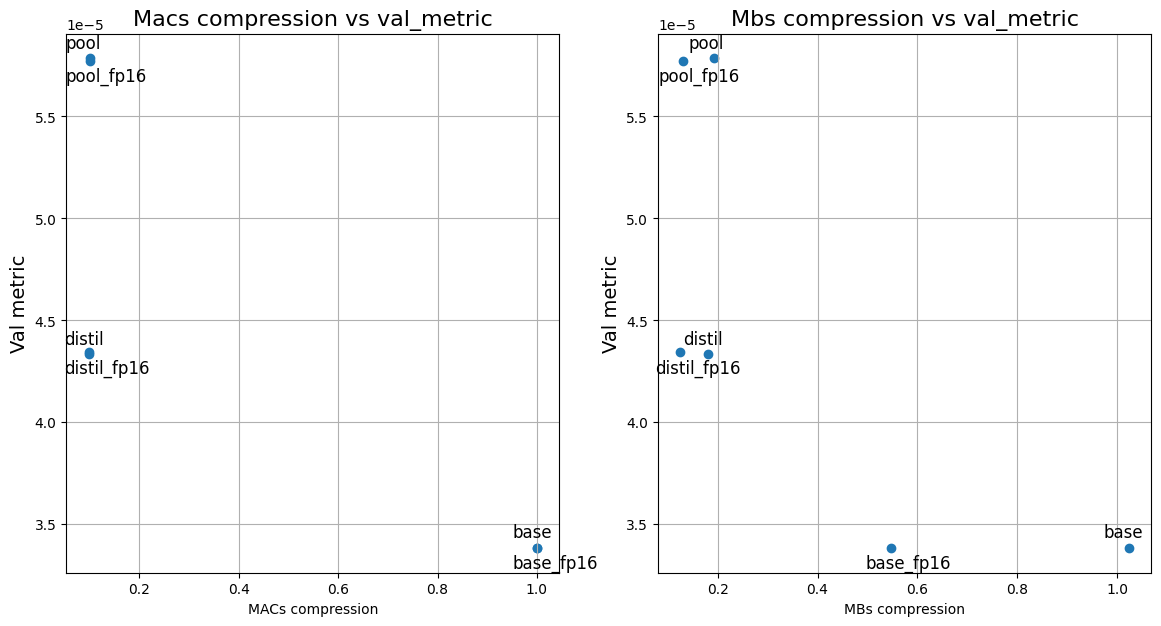

In [66]:
import matplotlib.pyplot as plt
import operator

def sum_tuples(a, b):
    return tuple(map(operator.add, a, b))

fig, axes = plt.subplots(ncols=2, figsize=(14, 7))
axes[0].scatter(macs, scores)
axes[1].scatter(mbs, scores)

for i, txt in enumerate(txts):
    coords = (-0.05, -1e-6) if 'fp16' in txt else (-0.05, 5e-7)
    coords_1 = (macs[i], scores[i])
    coords_2 = (mbs[i], scores[i])
    
    axes[0].annotate(txt, coords_1, xytext=sum_tuples(coords_1, coords), fontsize=12)
    axes[1].annotate(txt, coords_2, xytext=sum_tuples(coords_2, coords), fontsize=12)
    
for ax in axes:
    ax.grid()
    ax.set_ylabel('Val metric', fontsize=14)
    
axes[0].set_title('Macs compression vs val_metric', fontsize=16)
axes[0].set_xlabel('MACs compression')

axes[1].set_title('Mbs compression vs val_metric', fontsize=16)
axes[1].set_xlabel('MBs compression')

plt.savefig('fig.png')

In [57]:
base_model = utils.load_model('/home/dpozdeev/dla-kws/save/Base/1105_021522/Base_sched=False.tar')

In [67]:
test_input = melspec_val(torch.rand(size=[1, base_model.config.sample_rate * 2]).to(model.config.device))
print(test_input.size())
profile(base_model, test_input.unsqueeze(0))[0]  # -> (6.0 MACs, 3.0 parameters)

torch.Size([1, 40, 201])
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


3618432.0

In [ ]:
@torch.no_grad()
class StreamingKWS:
    def __init__(self, model, window_size):
        
        self.model = model
        self.buffer = []
        self.gru_outputs = []
        self.window_size = window_size
        
    def __call__(self, chunk):
        i

In [68]:
x = torch.rand([1, 40, 201]).to('cuda')
profile(base_model, (x, ))[0]

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


3618432.0

In [33]:
config = BaseConfig()

In [43]:
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 3, kernel_size=(5, 24), stride=(3, 15))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(36, 12, num_layers=2, batch_first=True)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=12, out_features=12, bias=True)
      (1): Tanh()
      (2): Linear(in_features=12, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=12, out_features=2, bias=True)
)

In [51]:
Metrics.get_macs(base_model.to('cuda'))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


1809216.0

In [49]:
Metrics.get_size_in_megabytes(base_model) / Metrics.get_size_in_megabytes(model.half())

10.344063993756707

In [ ]:
Metrics.get_size_in_megabytes

In [41]:
half_model = model.half()

In [42]:
Metrics.get_size_in_megabytes(base_model) / Metrics.get_size_in_megabytes(half_model)

6.525157997083131

In [29]:
class Half(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.config = model.config
        self.model = model.half()
        
    def forward(self, x):
        return self.model(x.half())

    
half_model = Half(model)
validation(half_model, val_loader, melspec_val, half_model.config.device)

102it [00:04, 25.23it/s]


4.342882752161334e-05

In [44]:
x = torch.rand([1, 1, 40, 201]).to('cuda')
base_model.conv[0](x).size()

torch.Size([1, 8, 18, 23])

In [53]:
x = torch.rand([1, 40, 201])
pool = nn.AvgPool2d(kernel_size=(1, 6), stride=(1, 3))
conv = nn.Conv2d(1, 4, kernel_size=(5, 6), stride=(2, 3))
conv(pool(x)).size()

torch.Size([4, 18, 21])

In [56]:
config = BaseConfig(
    hidden_size=12, cnn_out_channels=4, gru_num_layers=2, dropout=0.,
    kernel_size=(5, 16),
    stride=(3, 12),
    n_mels=40,
)

st_model = CRNN(config).cpu()

In [79]:
import torch
from torch import nn
import torch.nn.functional as F

class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNNPool(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.pool = nn.AvgPool2d(kernel_size=(1, 6), stride=(1, 3))
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1

        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=config.dropout,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)

    def forward(self, input):
        input = input.unsqueeze(dim=1)
        input = self.pool(input)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

In [96]:
config = BaseConfig(
    hidden_size=11, cnn_out_channels=5, gru_num_layers=2, dropout=0.,
    kernel_size=(5, 8),
    stride=(3, 4),
    n_mels=40,
)

pool_model = CRNNPool(config).to(config.device).cpu()

x = melspec_val(torch.rand(size=[1, 16000 * 2]).to('cuda')).cpu()
print(x.size())
profile(pool_model, (x,))

torch.Size([1, 40, 201])
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


(90967.0, 3574.0)

In [89]:
x = melspec_val(torch.rand(size=[1, 16000 * 2]).to('cuda')).unsqueeze(1).cpu()

pool = nn.AvgPool2d(kernel_size=(1, 6), stride=(1, 3))
print('pool', profile(pool, (x,)))
x = pool(x)

conv = nn.Conv2d(1, 6, kernel_size=(5, 9), stride=(3, 4))
print('conv', profile(conv, (x, )))

print(conv(x).size())
flatten = nn.Flatten(start_dim=1, end_dim=2)
conv_output = flatten(conv(x)).transpose(-1, -2)

gru = nn.GRU(
            input_size=72,
            hidden_size=12,
            num_layers=2,
            dropout=0,
            bidirectional=False,
            batch_first=True
        )

print('gru', profile(gru, (conv_output, )))

[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
pool (2640.0, 0)
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
conv (48600.0, 0)
torch.Size([1, 6, 12, 15])
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
gru (63000.0, 0)


In [54]:
x = torch.rand([1, 40, 201])
pool = nn.AvgPool2d(kernel_size=(1, 6), stride=(1, 3))
profile(pool, (x,))

[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.


(2640.0, 0)

In [34]:
from base_config import BaseConfig

path = '/home/dpozdeev/dla-kws/save/Base/1105_021522/Base_sched=False.tar'


def load_model_half(path):
    load_dict = torch.load(path)
    config_dict = load_dict['config_dict']
    config = BaseConfig(**config_dict)
    model = CRNNHalf(config)
    model.load_state_dict(load_dict['model_state'])

    return model.half()

base_model_half = load_model_half(path)
base_model_half.to('cuda')

CRNNHalf(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

In [35]:
validation(base_model_half, val_loader, melspec_val, base_model_half.config.device)

102it [00:04, 23.10it/s]


2.2772161569560494e-05

In [41]:
base_model.to('cuda')
validation(base_model, val_loader, melspec_val, base_model.config.device)

102it [00:04, 23.65it/s]


2.2772161569560497e-05

In [39]:
Metrics.get_size_in_megabytes(base_model) / Metrics.get_size_in_megabytes(base_model_half)

1.9557166307014147

In [151]:
torch.load('base_model.pth')

OrderedDict([('conv.0.weight',
              tensor([[[[ 0.0659,  0.0145, -0.0721, -0.0543,  0.0095,  0.0301,  0.0143,
                         -0.0281, -0.0091, -0.0093, -0.0262, -0.0442,  0.0563,  0.0644,
                         -0.0149,  0.0769,  0.0394, -0.0554,  0.0604, -0.0328],
                        [-0.0496, -0.0065,  0.0062,  0.0762, -0.0523,  0.0174, -0.0786,
                          0.0071,  0.0041, -0.0525,  0.0955,  0.0471, -0.0710,  0.0303,
                          0.0481,  0.0318, -0.0931,  0.0772,  0.0479, -0.0741],
                        [ 0.0237,  0.0634, -0.0248,  0.1112,  0.0607,  0.0637,  0.0746,
                          0.0118,  0.0726,  0.0389,  0.0466, -0.0834, -0.0461, -0.0462,
                         -0.0959,  0.0157, -0.0183, -0.0392, -0.1205, -0.0935],
                        [-0.0009, -0.0331,  0.0081,  0.1027, -0.0077, -0.0091,  0.0859,
                         -0.0311,  0.0745, -0.0548, -0.0069,  0.1179, -0.0435,  0.0768,
                         

In [152]:
config = TaskConfig(
    hidden_size=11, cnn_out_channels=3, gru_num_layers=2, dropout=0.,
    kernel_size=(5, 16),
    stride=(3, 12),
    n_mels=40,
)

mod_model = CRNN(config).to(config.device)

mod_model = mod_model.load_state_dict(torch.load('mod.tar'))
mod_model

AttributeError: Can't get attribute 'Config' on <module '__main__'>

In [116]:
config = TaskConfig(
    hidden_size=11, cnn_out_channels=3, gru_num_layers=2, dropout=0.,
    kernel_size=(5, 16),
    stride=(3, 12),
    n_mels=40,
)

config.num_epochs = 100

st_model = CRNN(config).to(config.device)

In [117]:
Metrics.get_macs(st_model)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


89222.0

In [100]:
keys_list = ['conv', 'gru', 'attention', 'classifier']

for key in keys_list:
    print(key, 100*Metrics.get_size_in_megabytes(getattr(st_model, key)))

conv 0.24175643920898438
gru 0.7182121276855469
attention 0.18606185913085938
classifier 0.10137557983398438


In [101]:
Metrics.get_size_in_megabytes(base_model) / Metrics.get_size_in_megabytes(st_model)

9.10337351487295

In [84]:
12 * 12 * 5 * 24

17280

In [87]:
config = TaskConfig(
    hidden_size=12, cnn_out_channels=3, gru_num_layers=2, dropout=0.,
    kernel_size=(5, 24),
    stride=(3, 15),
    n_mels=40,
)

config.num_epochs = 100

st_model = CRNN(config).to(config.device)

In [72]:
Metrics.get_macs(st_model)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


88584.0

In [76]:
Metrics.get_size_in_megabytes(base_model) / Metrics.get_size_in_megabytes(st_model)

7.0644727101420015

In [88]:
x = torch.rand([1, 40, 201]).to('cuda')
base_model.to('cuda')
st_model.to('cuda')
st_model.conv[0](x).size(), base_model.conv[0](x).size()

(torch.Size([3, 12, 12]), torch.Size([8, 18, 23]))

In [141]:
Metrics.get_macs(st_model)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


88152.0

In [139]:
x = melspec_val(torch.rand(size=[1, model.config.sample_rate * 2]).to(model.config.device)).unsqueeze(1).cpu()
conv = nn.Conv2d(1, 3, kernel_size=(5, 20), stride=(3, 13))
print('conv', profile(conv, (x, )))

flatten = nn.Flatten(start_dim=1, end_dim=2)
conv_output = flatten(conv(x)).transpose(-1, -2).to('cuda')

print('gru', profile(st_model.gru, (conv_output, )))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
conv (50400.0, 0)
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
gru (40656.0, 0)


In [82]:
Metrics.get_macs(base_model)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


904608.0

In [81]:
base_model.to('cuda')
profile(base_model, melspec_val(torch.rand([1, 32000]).to('cuda')).unsqueeze(0))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


(904608.0, 25387.0)

In [30]:
base_model.to('cuda')
Metrics.get_macs(base_model)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


3618432.0

In [35]:
config = TaskConfig(
    hidden_size=12, cnn_out_channels=4, gru_num_layers=2, dropout=0.,
    kernel_size=(5, 20),
    stride=(3, 10),
    n_mels=40,
)

config.num_epochs = 100

st_model = CRNN(config).to(config.device)
Metrics.get_macs(st_model)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


315144.0

In [27]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    dropout: float = 0.1
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

In [49]:
import torch.nn.utils.prune as prune

In [ ]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNNAdaptive(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config
        
        self.pool = nn.AdaptiveAvgPool2d((config.n_mels * 3 // 4), )
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=config.dropout,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

In [73]:
(np.abs(m) < 1e-4).sum()

800

In [87]:
from copy import deepcopy
conv = deepcopy(base_model.conv[0]).cpu()
x = torch.rand([2, 1, 40, 101])
profile(conv, (x,))[0]

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.


316800.0

In [31]:
config = TaskConfig(
    hidden_size=12, cnn_out_channels=3, gru_num_layers=2, dropout=0.,
    kernel_size=(5, 25),
    stride=(3, 15),
    n_mels=40,
)

config.num_epochs = 100

st_model = CRNN(config).to(config.device)

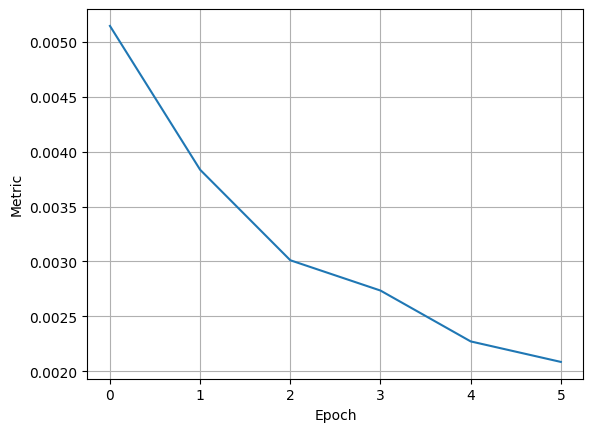

END OF EPOCH 5
Val_metric 0.002085720538851644


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 339/405 [00:17<00:03, 20.74it/s]

In [ ]:
history = defaultdict(list)

config = TaskConfig(
    hidden_size=12, cnn_out_channels=3, gru_num_layers=2, dropout=0.,
    kernel_size=(5, 25),
    stride=(3, 15),
    n_mels=40,
)

config.num_epochs = 100

st_model = CRNN(config).to(config.device)

print(st_model)

opt = torch.optim.Adam(
    st_model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, config.num_epochs)

history = train_distillation(st_model, base_model, opt, config, 0.9, temp=10)

In [46]:
config = TaskConfig(
    hidden_size=12, cnn_out_channels=3, gru_num_layers=2, dropout=0.,
    kernel_size=(5, 25),
    stride=(3, 15),
)
config.num_epochs = 50

st_model = CRNN(config).to(config.device)
get_number_of_flops_per_layer(st_model)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
torch.Size([2, 1, 40, 201])
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


{'conv': 108000.0, 'gru': 69696.0, 'attention': 3744.0, 'classifier': 48.0}

In [35]:
print(history)
eval_metric = Metrics(base_model)
eval_metric(st_model)

defaultdict(<class 'list'>, {'val_metric': [0.0025410772408029276, 0.0014148190020440343, 0.0012603162113950025, 0.001142322876847273, 0.0009793312497640954, 0.0008783364745011914, 0.0007147510764336921, 0.0005731262534647208, 0.00047800951256922166, 0.0004708633743408285, 0.00043664545651067653, 0.00038302704149429783, 0.0003283762407463851, 0.00030826262162421425, 0.0002971003238737261, 0.00026298982190003434, 0.0002830646519629278, 0.00023951945726348258, 0.00022503025173651903, 0.00020381263631184078, 0.0001898038183651575, 0.0001841256968417202, 0.00015752535349887014, 0.00016001382084019787, 0.00015311533583642117, 0.00014184860600326333, 0.0001360362146592508, 0.00012752052426099011, 0.00013887676730786472, 0.00011247036926140112, 0.00011530495436243392, 0.00011202280319281698, 9.884645813370022e-05, 0.0001071115115335538, 9.487207144467316e-05, 8.643992671254815e-05, 9.378001023732786e-05, 0.00010221812251703398, 0.00010180039418635548, 9.295052112355195e-05, 8.489433188903762e

102it [00:03, 28.60it/s]


[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


102it [00:03, 29.47it/s]


Macs improvement 4.31777306833152
Mbs imporvement 5.041694055779885
Val metric 7.16463762589474e-05


In [ ]:
history = defaultdict(list)

config = TaskConfig(
    hidden_size=8, cnn_out_channels=3, gru_num_layers=2, dropout=0.,
    kernel_size=(5, 20),
    stride=(2, 8),
)
config.num_epochs = 50

st_model = CRNN(config).to(config.device)

print(st_model)

opt = torch.optim.Adam(
    st_model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

history = train_distillation(st_model, base_model, opt, config, 0.8, temp=10)

In [ ]:
history = defaultdict(list)

config = TaskConfig(
    hidden_size=8, cnn_out_channels=3, gru_num_layers=2, dropout=0.,
    kernel_size=(5, 20),
    stride=(2, 8),
)
config.num_epochs = 40

st_model = CRNN(config).to(config.device)

print(st_model)

opt = torch.optim.Adam(
    st_model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

history = train_distillation(st_model, base_model, opt, config, 0.9, temp=5)

In [74]:
config = TaskConfig(
    hidden_size=16, cnn_out_channels=4, gru_num_layers=1, dropout=0.,
    kernel_size=(5, 20),
    stride=(2, 8),
)
config.num_epochs = 30

st_model = CRNN(config).to(config.device)


In [77]:
sum(get_number_of_flops_per_layer(st_model).values())

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
torch.Size([2, 1, 40, 201])
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


1256704.0

In [99]:
base_model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

In [89]:
config = TaskConfig(
    hidden_size=8, cnn_out_channels=3, gru_num_layers=2, dropout=0.,
    kernel_size=(5, 20),
    stride=(2, 8),
)
config.num_epochs = 30

st_model = CRNN(config).to(config.device)

x = torch.rand(size=[2, 1, 40, 101])

st_model.conv(x).size()

torch.Size([2, 72, 11])

## Streaming

In [27]:
class Half(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.config = model.config
        self.model = model.half()
        
    def forward(self, x):
        return self.model(x.half())

In [63]:
path = '/home/dpozdeev/dla-kws/save/C_Dist/1106_114532/C_Dist_a=0.9_T=20_sched=False.tar'

best_model = utils.load_model(path)
best_model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 3, kernel_size=(5, 24), stride=(3, 15))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(36, 12, num_layers=2, batch_first=True)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=12, out_features=12, bias=True)
      (1): Tanh()
      (2): Linear(in_features=12, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=12, out_features=2, bias=True)
)

In [169]:
class Streaming(nn.Module):
    def __init__(self, model, melspec, window_size=7500, step_size=3750, is_half=True):
        super().__init__()
        
        
        self.window_size = window_size
        self.step_size = step_size
        
        self.is_half = is_half
        self.model = model if not is_half else model.half()
        config = self.model.config
        self.device = config.device
        
        self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
        ).to(config.device)
        
        
        self.buffer = torch.zeros([1, 0])
        self.gru_outputs = torch.zeros([1, 0, 1]).to(self.device)
        self.hidden = torch.zeros([1, 0]).to(self.device)
        
        self.prev_proba = 0.
        
    def forward(self, chunk):
        assert len(chunk.size()) == 2
        max_proba = 0.
        
        if self.buffer.size()[-1] < self.window_size:
            need_len = self.window_size - self.buffer.size()[-1]
            
            self.buffer = torch.cat([self.buffer, chunk[:, :need_len]], dim=1)
            chunk = chunk[:, need_len:]
            
            if self.buffer.size()[-1] == self.window_size:
                max_proba = self.model_forward(self.buffer)
            else:
                return self.prev_proba

        chunks = torch.split(chunk, self.step_size, dim=-1)
        for chunk in chunks:
            
            self.buffer = torch.cat([self.buffer[:, self.step_size:], chunk], dim=1)
            
            if self.buffer.size()[-1] == self.window_size:
                cur_proba = self.model_forward(self.buffer)
                max_proba = max(max_proba, cur_proba)
        
        self.prev_proba = max_proba
        return max_proba
    

    def model_forward(self, x):
        
        if self.gru_outputs is not None:
            x = x[:, -self.step_size:]
        
        x = x.to(self.device)
        x = torch.log(self.melspec(x).clamp_(min=1e-9, max=1e9))
        x = x if not self.is_half else x.half()
        input = x.unsqueeze(dim=1)
        conv_output = self.model.conv(input).transpose(-1, -2)
        
        hidden = None if self.hidden.size()[-1] == 0 else self.hidden
        gru_outputs, hidden = self.model.gru(conv_output, hidden)
        self.hidden = hidden
        
        if self.gru_outputs.size()[1] != 0:
            gru_outputs = torch.cat([self.gru_outputs[:, self.step_size:, :], gru_outputs], dim=1)
        
        self.gru_outputs = gru_outputs
        
        contex_vector = self.model.attention(gru_outputs)
        output = self.model.classifier(contex_vector)
        return F.softmax(output, dim=-1)[0][1].item()
        
        

In [163]:
paths = [
    '/home/dpozdeev/dla-kws/speech_commands/right/0a7c2a8d_nohash_1.wav',
    '/home/dpozdeev/dla-kws/speech_commands/sheila/0b09edd3_nohash_0.wav',
    '/home/dpozdeev/dla-kws/speech_commands/stop/0ab3b47d_nohash_0.wav'
]

audio = torch.zeros([1, 32000])
for path in paths:
    wav, sr = torchaudio.load(path)
    audio = torch.cat([audio, wav], dim=1)
    
audio = torch.cat([audio, torch.zeros([1, 16000])], dim=1)

In [91]:
melspec_val(torch.rand([1, 3750]).to('cuda')).size()

torch.Size([1, 40, 24])

In [170]:
streaming = Streaming(best_model.to('cuda'), melspec_val)
hop_size = 1000

x = []
for i in range(int(audio.size()[-1] / hop_size)):
    x.append(streaming(audio[:, i * hop_size:i * hop_size + 7500]))

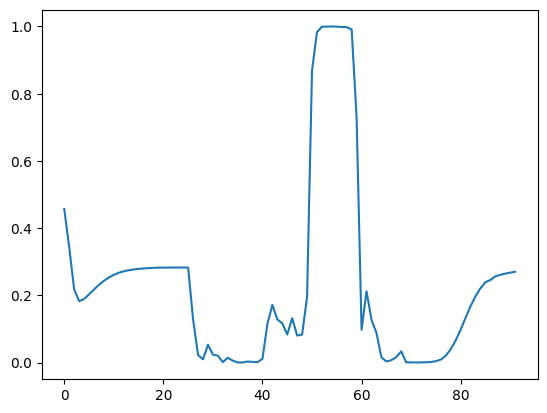

In [166]:
plt.plot(np.arange(i+1), x)

In [171]:
import torch
import io


m = torch.jit.script(streaming)

# Save to file
torch.jit.save(m, 'stream_jit.pt')

In [172]:
m = torch.jit.load('/home/dpozdeev/dla-kws/stream_jit.pt')
m(audio)

0.99755859375

In [ ]:
torch.jit.save(streaming, 'stream_jit.pth')

In [140]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))



class Streaming(nn.Module):
    def __init__(self, model, melspec, window_size=7500, step_size=3750, is_half=True):
        super().__init__()
        
        
        self.window_size = window_size
        self.step_size = step_size
        
        self.is_half = is_half
        self.model = model if not is_half else model.half()
        config = self.model.config
        self.device = config.device
        
        self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
        ).to(config.device)
        
        
        self.buffer = torch.zeros([1, 0])
        self.gru_outputs = None
        self.hidden = None
        
        self.prev_proba = 0
        
    def forward(self, chunk):
        assert len(chunk.size()) == 2
        max_proba = 0
        
        if self.buffer.size()[-1] < self.window_size:
            need_len = self.window_size - self.buffer.size()[-1]
            
            self.buffer = torch.cat([self.buffer, chunk[:, :need_len]], dim=1)
            chunk = chunk[:, need_len:]
            
            if self.buffer.size()[-1] == self.window_size:
                max_proba = self.model_forward(self.buffer)
            else:
                return self.prev_proba

        chunks = torch.split(chunk, self.step_size, dim=-1)
        for chunk in chunks:
            
            self.buffer = torch.cat([self.buffer[:, self.step_size:], chunk], dim=1)
            
            if self.buffer.size()[-1] == self.window_size:
                cur_proba = self.model_forward(self.buffer)
                max_proba = max(max_proba, cur_proba)
        
        self.prev_proba = max_proba
        return max_proba
    

    def model_forward(self, x):
        
        if self.gru_outputs is not None:
            x = x[:, -self.step_size:]
        
        x = x.to(self.device)
        x = torch.log(self.melspec(x).clamp_(min=1e-9, max=1e9))
        x = x if not self.is_half else x.half()
        input = x.unsqueeze(dim=1)
        conv_output = self.model.conv(input).transpose(-1, -2)
        
        gru_outputs, hidden = self.model.gru(conv_output, self.hidden)
        self.hidden = hidden
        
        if self.gru_outputs is not None:
            gru_outputs = torch.cat([self.gru_outputs[:, self.step_size:, :], gru_outputs], dim=1)
        
        self.gru_outputs = gru_outputs
        
        contex_vector = self.model.attention(gru_outputs)
        output = self.model.classifier(contex_vector)
        return F.softmax(output, dim=-1)[0][1].item()
        
        